In [ ]:
## Data loading 

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader

##set root_dir to the correct path to your dataset folder
root_dir = '/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/dataset/argoverse/test_obs/data'

afl = ArgoverseForecastingLoader(root_dir)

print('Total number of sequences:',len(afl))

In [ ]:
print(afl[0])

In [ ]:
argoverse_forecasting_data = afl[0]
print(argoverse_forecasting_data.track_id_list)

In [ ]:
## Visualize

from argoverse.visualization.visualize_sequences import viz_sequence
seq_path = f"{root_dir}/1.csv"
viz_sequence(afl.get(seq_path).seq_df, show=True)
seq_path = f"{root_dir}/2.csv"
viz_sequence(afl.get(seq_path).seq_df, show=True)

In [1]:
import pickle
import numpy as np

with open('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/prediction.pkl', 'rb') as file:
    predictions = pickle.load(file)
    
with open('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/gts.pkl', 'rb') as file:
    gts = pickle.load(file)

with open('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/saved_pred_idx.pkl', 'rb') as file:
    min_idx = pickle.load(file)  # For each key, choose the list of predictions with lowest fde value.

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

def plot_seq(obs_traj_abs, pred_traj_fake_abs, argo_id, num_guess, horizon):
    
    obsv_color = "#ECA154"
    hist_color = "#d33e4c"
    pred_color = "#007672"
    
    filename = '/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/dataset/argoverse/val/data/'+str(k)+'.csv'
    df = pd.read_csv(filename)
    
    filename_train = '/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/dataset/argoverse/train/data/'+str(k)+'.csv'
    df_train = pd.read_csv(filename_train)
    
    
    city = df['CITY_NAME'][0]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    x_min = np.min(np.concatenate((obs_traj_abs[:,0], pred_traj_fake_abs[:,0]),axis=0))
    x_max = np.max(np.concatenate((obs_traj_abs[:,0], pred_traj_fake_abs[:,0]),axis=0))
    y_min = np.min(np.concatenate((obs_traj_abs[:,1], pred_traj_fake_abs[:,1]),axis=0))
    y_max = np.max(np.concatenate((obs_traj_abs[:,1], pred_traj_fake_abs[:,1]),axis=0))
    
    plt.figure(0, figsize=(8, 7))
    
    viz_sequence(df, show=True)
    viz_sequence(df_train, show=True)

    lane_centerlines = []

    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    
    plt.plot(
        obs_traj_abs[:,0],
        obs_traj_abs[:,1],
        color= obsv_color,
        label="Observed",
        alpha=1,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        obs_traj_abs[-1,0],
        obs_traj_abs[-1,1],
        "o",
        color=obsv_color,
        alpha=1,
        linewidth=3,
        zorder=15,
        markersize=9,
    )

    # plt.plot(
    #     pred_traj_hist[:,0,0],
    #     pred_traj_hist[:,0,1],
    #     color=hist_color,
    #     label="History",
    #     alpha=0.8,
    #     linewidth=3,
    #     zorder=20,
    # )
    # 
    # plt.plot(
    #     pred_traj_hist[-1,0,0],
    #     pred_traj_hist[-1,0,1],
    #     "o",
    #     color=hist_color,
    #     alpha=1,
    #     linewidth=3,
    #     zorder=20,
    #     markersize=9
    # )

    plt.plot(
        pred_traj_fake_abs[:,0],
        pred_traj_fake_abs[:,1],
        color=pred_color,
        label="Prediction",
        alpha=1,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_fake_abs[-1,0],
        pred_traj_fake_abs[-1,1],
        "o",
        color=pred_color,
        alpha=1,
        linewidth=3,
        zorder=15,
        markersize=9
    )
    
    plt.title('File ID: '+str(argo_id)+'; '+'Guess: '+str(num_guess)+'; '+'Horizon: '+str(horizon))

    plt.legend()
    plt.show()    

30


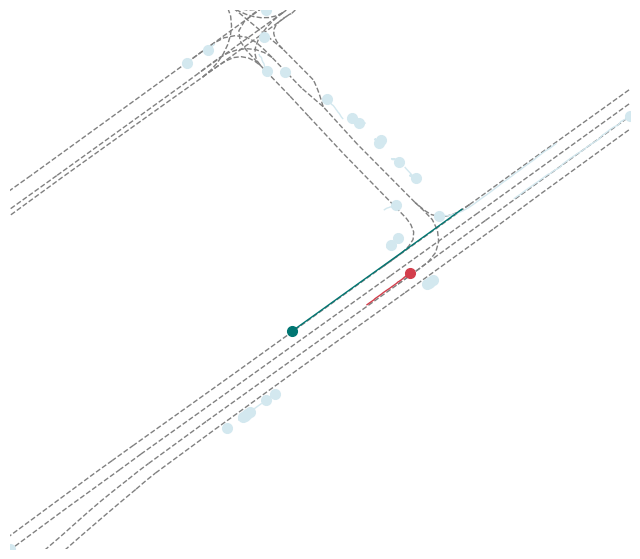

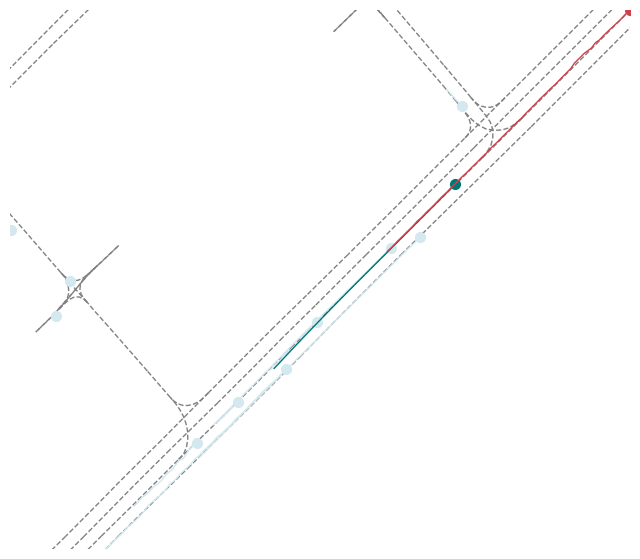

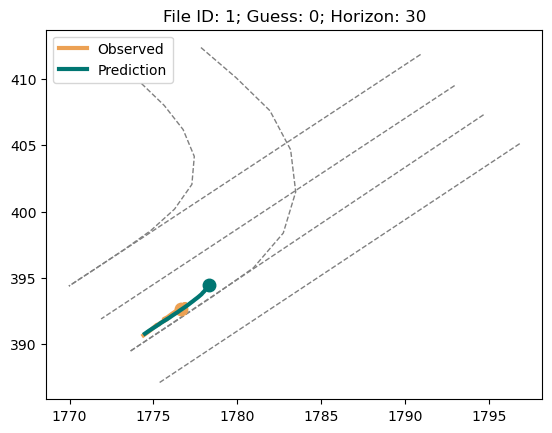

30


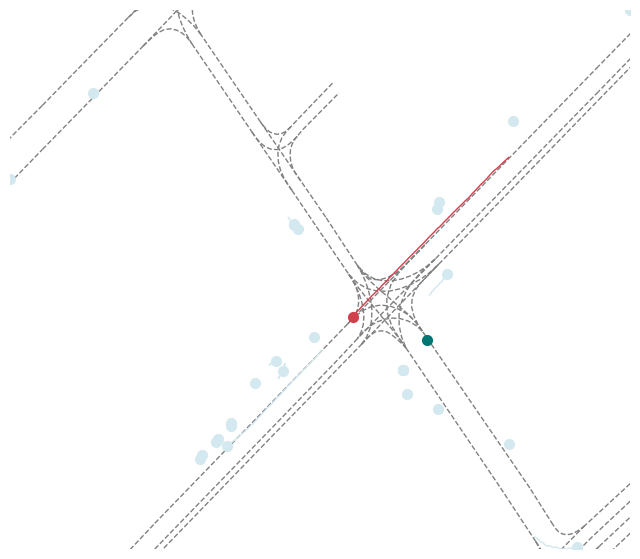

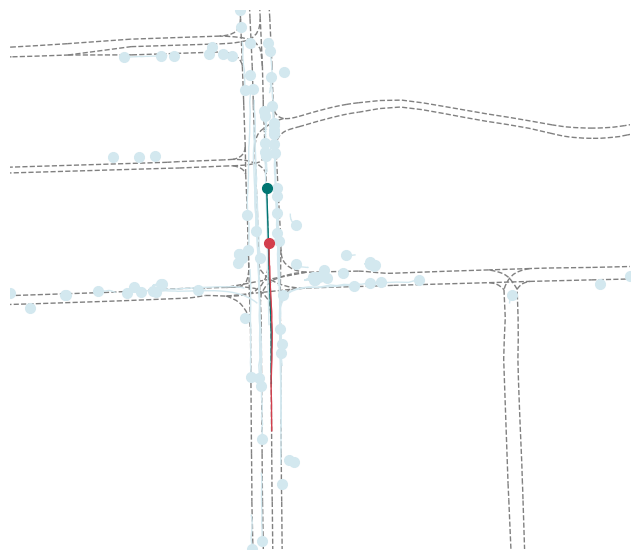

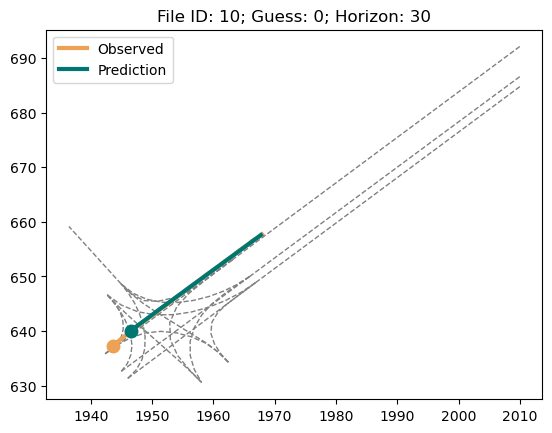

In [76]:
import itertools

max_guesses = 1
forecasted_probabilities = None
horizon = 30
# for k, v in gts.items():
for k, v in itertools.islice(gts.items(), 2):  # k is same as 'argo_id = int(Path(filename).stem)'
    curr_min_ade = float("inf")
    curr_min_fde = float("inf")
    min_idx = 0
    max_num_traj = min(max_guesses, len(predictions[k]))

    # If probabilities available, use the most likely trajectories, else use the first few
    if forecasted_probabilities is not None:
        sorted_idx = np.argsort([-x for x in forecasted_probabilities[k]], kind="stable")
        # sorted_idx = np.argsort(forecasted_probabilities[k])[::-1]
        pruned_probabilities = [forecasted_probabilities[k][t] for t in sorted_idx[:max_num_traj]]
        # Normalize
        prob_sum = sum(pruned_probabilities)
        pruned_probabilities = [p / prob_sum for p in pruned_probabilities]
    else:
        sorted_idx = np.arange(len(predictions[k]))
    pruned_trajectories = [predictions[k][t] for t in sorted_idx[:max_num_traj]]

    for j in range(len(pruned_trajectories)): #j is from 0 to 6 for max_guesses
        print(len(pruned_trajectories[j]))
        x_pred = pruned_trajectories[j][:horizon][:,0]
        y_pred = pruned_trajectories[j][:horizon][:,1]
        x_gts = v[:horizon][:,0].numpy()
        y_gts = v[:horizon][:,1].numpy()
        traj_pred = pruned_trajectories[j][:horizon]
        traj_gts = v[:horizon].numpy()
        #if k == 10001 and j == 0: 
        plot_seq(traj_gts,traj_pred,k,j,horizon)
        #     print(x_pred)
        #     print(y_pred)
        #     print(x_gts)
        #     print(y_gts)
        #     print(traj_pred)
        
            
        
        
        

In [ ]:
# Preprocess gts and predictions

flattened_gts = []
flattened_pred = []

print('Check issues with preprocess:')

print(f'Size of gts is: {len(gts)}')
print(f'Size of predictions is: {len(predictions)}')

for key in gts:
    for array in gts[key]:
        # Append each pair as a tuple
        flattened_gts.append((array[0], array[1])) 

print(flattened_gts[1])

for key in predictions:
    for array in predictions[key][0]:  # 0 denotes lowest fde for each list of predictions in each key 
        # Append each pair as a tuple
        flattened_pred.append((array[0], array[1]))

# Split the tuples into two lists: one for 'X' and one for 'Y'
X_data_gts = [item[0].numpy() for item in flattened_gts]
Y_data_gts = [item[1].numpy() for item in flattened_gts]

print(X_data_gts[1])

X_data_pred = [item[0] for item in flattened_pred]
Y_data_pred = [item[1] for item in flattened_pred]

# Create the new dictionary for gts
gts_pred = {'X': X_data_gts, 'Y': Y_data_gts, 'X_PRED': X_data_pred, 'Y_PRED': Y_data_pred}

print(gts_pred['X'][0])
print(gts_pred['Y'][0])
print(gts_pred['X_PRED'][0])
print(gts_pred['Y_PRED'][0])



In [ ]:
import pandas as pd
gts_pred_df = pd.DataFrame(gts_pred)  # Save all predictions and gts in "X,Y,X_PRED,Y_PRED"
gts_pred_df.to_csv('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/output.csv', index=False)

In [ ]:
# Load the data from both CSV files
df1 = pd.read_csv('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/output.csv')  
df2 = pd.read_csv('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/dataset/argoverse/val/data/1.csv')  

# Round the 'X' values to some decimal places
df1['X_rounded'] = df1['X'].round(3)
df2['X_rounded'] = df2['X'].round(3)

# Merge the dataframes based on the rounded 'X' values
merged_df = pd.merge(df1, df2[['TIMESTAMP', 'TRACK_ID', 'OBJECT_TYPE', 'CITY_NAME', 'X_rounded']], on='X_rounded', how='inner')

# Drop the rounded 'X' column if not needed
merged_df.drop('X_rounded', axis=1, inplace=True)
merged_df.to_csv('/Users/xinyufang/Library/CloudStorage/Box-Box/Ferrari_SpA/crat-pred/result_data/output_combined.csv', index=False)


In [ ]:
#!/usr/bin/env python

"""A simple python script template."""
from collections import defaultdict
from typing import Dict, List, Optional

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interp

from argoverse.map_representation.map_api import ArgoverseMap

_ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}


def interpolate_polyline(polyline: np.ndarray, num_points: int) -> np.ndarray:
    duplicates = []
    for i in range(1, len(polyline)):
        if np.allclose(polyline[i], polyline[i - 1]):
            duplicates.append(i)
    if polyline.shape[0] - len(duplicates) < 4:
        return polyline
    if duplicates:
        polyline = np.delete(polyline, duplicates, axis=0)
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.column_stack(interp.splev(u, tck))


def viz_sequence_aug(
    df: pd.DataFrame,
    lane_centerlines: Optional[List[np.ndarray]] = None,
    show: bool = True,
    smoothen: bool = False,
) -> None:

    # Seq data
    city_name = df["CITY_NAME"].values[0]

    if lane_centerlines is None:
        # Get API for Argo Dataset map
        avm = ArgoverseMap()
        seq_lane_props = avm.city_lane_centerlines_dict[city_name]

    plt.figure(0, figsize=(8, 7))

    x_min = min(df["X_PRED"])
    x_max = max(df["X_PRED"])
    y_min = min(df["Y_PRED"])
    y_max = max(df["Y_PRED"])

    if lane_centerlines is None:

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        lane_centerlines = []
        # Get lane centerlines which lie within the range of trajectories
        for lane_id, lane_props in seq_lane_props.items():

            lane_cl = lane_props.centerline

            if (
                np.min(lane_cl[:, 0]) < x_max
                and np.min(lane_cl[:, 1]) < y_max
                and np.max(lane_cl[:, 0]) > x_min
                and np.max(lane_cl[:, 1]) > y_min
            ):
                lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(
            lane_cl[:, 0],
            lane_cl[:, 1],
            "--",
            color="grey",
            alpha=1,
            linewidth=1,
            zorder=0,
        )
    frames = df.groupby("TRACK_ID")

    plt.xlabel("Map X")
    plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#d3e8ef", "AV": "#007672"}
    # Color code OBJECT_TYPE
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X_PRED"].values
        cor_y = group_data["Y_PRED"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D(
        [],
        [],
        color="green",
        marker="o",
        linestyle="None",
        markersize=7,
        label="Others",
    )
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    plt.axis("off")
    if show:
        plt.show()


In [ ]:
# Visualization

#from argoverse.visualization.visualize_sequences import viz_sequence
viz_sequence_aug(merged_df, show=True, smoothen=True)